In [42]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from sklearn import svm
import seaborn as sns

In [160]:
def plot_conf(confusion_matrix):
    #turn this into a dataframe
    matrix_df = pd.DataFrame(confusion_matrix)

    labels = ['Drinking Water', 'Non-drinking Water']
    #plot the result
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    #set axis titles
    ax.set_title('Confusion Matrix')
    ax.set_xlabel("Predicted label", fontsize =15)
    ax.set_ylabel("True Label", fontsize=15)
    plt.show()

## Data loading and preprocessing

In [161]:
# load and seperate data
data = pd.read_csv("water_potability.csv") 
cols = data.columns
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [162]:
# fill missing values 
imp_mean = SimpleImputer()
transformed = imp_mean.fit_transform(data)
transformed = pd.DataFrame(transformed, columns = cols)
transformed.head()
_data_shuffled = transformed.sample(frac=1).reset_index(drop=True)
data_shuffled.head()
print(len(data_shuffled[data_shuffled.Potability==1]))

1998


In [166]:
train , test = train_test_split(data_shuffled,test_size=0.3)
x_train = train.iloc[:,:-1]
y_train = train.Potability
x_test = test.iloc[:,:-1]
y_test = test.Potability

## Initial Decision Tree Classifier

Train on all dataset features


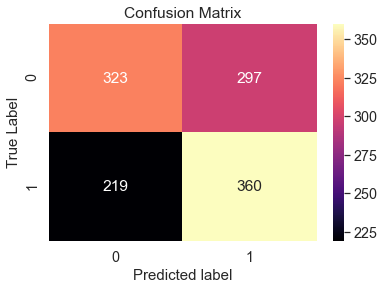

<Figure size 720x504 with 0 Axes>

array([0.52096774, 0.62176166])

In [167]:
# Train on all dataset features
print('Train on all dataset features')
clf = tree.DecisionTreeClassifier( max_depth = 10 )
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
sklearn.metrics.accuracy_score(y_test, y_pred)
sklearn.metrics.classification_report(y_test, y_pred)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

Train on selected features (TSS,TDS)


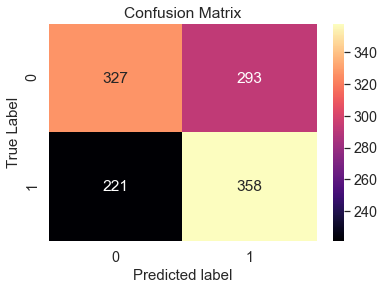

<Figure size 720x504 with 0 Axes>

array([0.52741935, 0.61830743])

In [169]:
# Train on selected dataset features
print('Train on selected features (TSS,TDS)')
selected_features = pd.concat([x_train.Solids, x_train.Turbidity], axis=1)
clf = clf.fit(selected_features,y_train)
test_features = pd.concat([x_test.Solids, x_test.Turbidity], axis=1)
y_pred = clf.predict(test_features)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

## Starting hyperparameter tuning: tree depth and spliting criterion

from sklearn.model_selection import cross_val_score

X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
Y = data_shuffled.Potability

prev = {
    'depth' : 0,
    'accuracy' : 0,
    'clf' : X
}

clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, X, Y, cv=10)


for i in range(1,40):
    clf = tree.DecisionTreeClassifier( max_depth = i )
    scores_avg = np.average(cross_val_score(clf, X, Y, cv=10))
    if(prev['accuracy'] < scores_avg):
        prev['depth'] = i
        prev['accuracy'] = scores_avg
        prev['clf'] = clf
print('Best model is:')
prev

## Stratified shuffle split for balancing ratio of classes b/w test and train

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

def genSSS(X, Y, folds=10, test_size=10):
    sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits=folds, test_size=test_size)

    x_train_folds = []
    x_test_folds = []
    y_train_folds = []
    y_test_folds = []
    prev = { 'depth' : 0, 'accuracy' : 0, 'clf' : X }
    
    for train_index, test_index in sss.split(X, Y):
        x_train_folds.append(X.iloc[train_index])
        y_train_folds.append(Y.iloc[train_index])
        x_test_folds.append(X.iloc[test_index])
        y_test_folds.append(Y.iloc[test_index])
        
    return [x_train_folds,y_train_folds], [x_test_folds, y_test_folds]

## Apply normalization to rescale the data for TSS to the range of our sensor

In [15]:
def normalizeTSS(tss):
    tss_np = np.array(tss)
    tss_n = (1000*(tss_np - np.min(tss_np))/np.ptp(tss_np)).astype(float)
    return tss_n

In [16]:
from sklearn import tree
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
print(X.shape)
Y = np.array(data_shuffled.Potability)
clf1 = tree.DecisionTreeClassifier( criterion='entropy')
clf1 = clf.fit(X,Y)

(3276, 2)


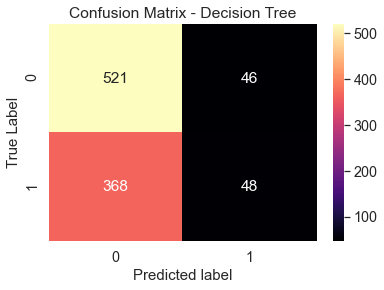

<Figure size 720x504 with 0 Axes>

array([0.91887125, 0.11538462])

In [31]:
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = clf1.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

In [64]:
from joblib import dump, load
dump(clf1, 'tree.joblib') 

['tree.joblib']

## Trying to resample the data: down and upsampling

In [102]:
from sklearn.utils import resample

selected_features = pd.concat([_data_shuffled.Solids, _data_shuffled.Turbidity], axis=1)
df = pd.concat([selected_features, _data_shuffled.Potability], axis=1)

# Separate majority and minority classes
df_majority = df[df.Potability==0]
df_minority = df[df.Potability==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority), # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(len(df_majority_downsampled))
print(len(df_minority))
data_shuffled = df_downsampled.sample(frac=1).reset_index(drop=True)
len(data_shuffled)

1278
1278


2556

In [103]:
from sklearn import tree
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
print(X.shape)
Y = np.array(data_shuffled.Potability)
clf1 = tree.DecisionTreeClassifier( criterion='gini')
clf1 = clf1.fit(X,Y)
clf2 = tree.DecisionTreeClassifier( criterion='entropy')
clf2 = clf2.fit(X,Y)

(2556, 2)


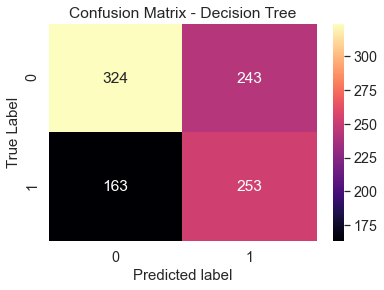

<Figure size 720x504 with 0 Axes>

0.5869786368260427

In [104]:
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = clf1.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
metrics.accuracy_score(y_test, y_pred)

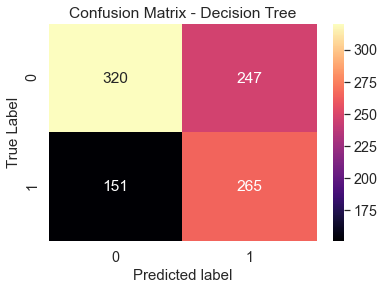

<Figure size 720x504 with 0 Axes>

0.595116988809766

In [105]:
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = clf2.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
metrics.accuracy_score(y_test, y_pred)

In [106]:
selected_features = pd.concat([_data_shuffled.Solids, _data_shuffled.Turbidity], axis=1)
df = pd.concat([selected_features, _data_shuffled.Potability], axis=1)

# Separate majority and minority classes
df_majority = df[df.Potability==0]
df_minority = df[df.Potability==1]
print(len(df_majority))
print(len(df_minority))


# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
print(len(df_upsampled[df_upsampled.Potability==0]))
print(len(df_upsampled[df_upsampled.Potability==1]))
data_shuffled = df_upsampled.sample(frac=1).reset_index(drop=True)
len(data_shuffled)

1998
1278
1998
1998


3996

In [107]:
from sklearn import tree
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
print(X.shape)
Y = np.array(data_shuffled.Potability)
clf1_g = tree.DecisionTreeClassifier( criterion='gini')
clf1_g = clf1_g.fit(X,Y)
clf2_g = tree.DecisionTreeClassifier( criterion='gini')
clf2_g = clf2_g.fit(X,Y)

(3996, 2)


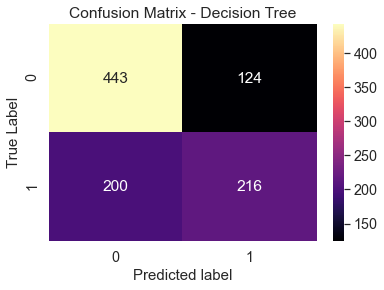

<Figure size 720x504 with 0 Axes>

0.6703967446592065

In [108]:
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = clf1_g.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
metrics.accuracy_score(y_test, y_pred)

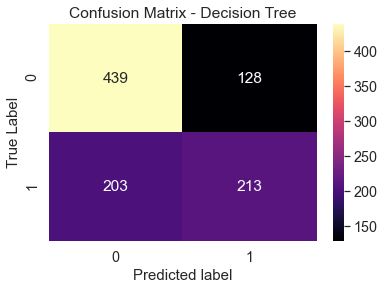

<Figure size 720x504 with 0 Axes>

0.6632756866734486

In [109]:
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = clf2_g.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
metrics.accuracy_score(y_test, y_pred)

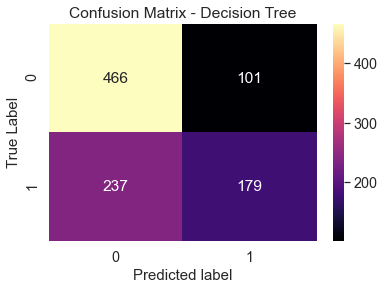

<Figure size 720x504 with 0 Axes>

0.6561546286876907

In [111]:
y_pred1 = clf1.predict(X_p)
y_pred2 = clf2.predict(X_p)
y_pred1g = clf1_g.predict(X_p)
y_pred2g = clf2_g.predict(X_p)
y_pred = []
for i,_ in enumerate(y_pred2):
    y_pp = y_pred1[i]+y_pred2[i]+y_pred1g[i]+y_pred2g[i]
    if y_pp > 2:
        y_pred.append(1)
    else:
        y_pred.append(0)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
metrics.accuracy_score(y_test, y_pred)

In [114]:
from joblib import dump, load
dump(clf1, 'tree1')
dump(clf2, 'tree2') 
dump(clf1_g, 'tree1_g') 
dump(clf2_g, 'tree2_g') 

['tree2_g']

In [144]:
def forest_pred(tds,tss):
    testt = np.array([tds,tss]).reshape(1,2)
    y_pred1 = clf1.predict(testt)
    y_pred2 = clf2.predict(testt)
    y_pred1g = clf1_g.predict(testt)
    #y_pred2g = clf2_g.predict(testt)

    y_pp = y_pred1+y_pred2+y_pred1g+y_pred2g
    print(y_pp)
    if y_pp > 2:
        return True
    else:
        return False

## Trying sklearn built in forest classifier 

Performance of Downsampling + Gini cireterion forest


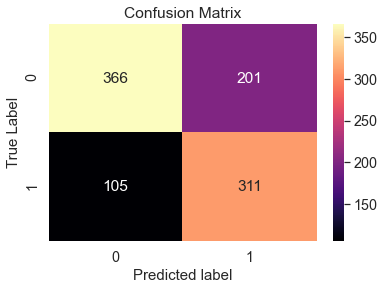

<Figure size 720x504 with 0 Axes>

0.688708036622584

Performance of Upsampling + Gini cireterion forest


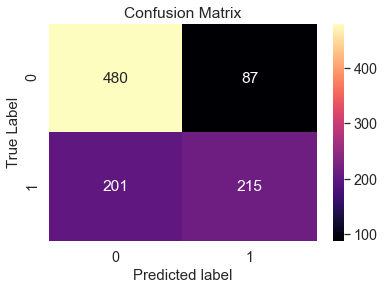

<Figure size 720x504 with 0 Axes>

0.7070193285859614

Performance of Downsampling + Entropy cireterion forest


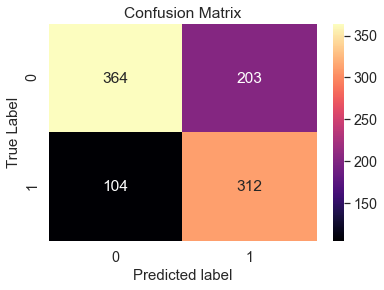

<Figure size 720x504 with 0 Axes>

0.6876907426246185


Performance of Upsampling + Entropy cireterion forest


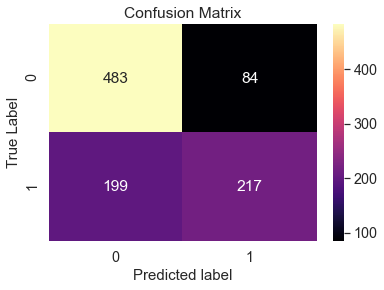

<Figure size 720x504 with 0 Axes>

0.7121057985757884


In [164]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Training on downsampling + Gini cireterion model
data_shuffled = df_downsampled.sample(frac=1).reset_index(drop=True)
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
Y = np.array(data_shuffled.Potability)
rf_d = RandomForestClassifier(n_estimators = 2000, random_state = 42)
rf_d = rf_d.fit(X,Y)

# Test on stratified folds + visualizing performance
print('Performance of Downsampling + Gini cireterion forest')
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = rf_d.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
print(metrics.accuracy_score(y_test, y_pred))

# Training on upsampling + Gini cireterion model
data_shuffled = df_upsampled.sample(frac=1).reset_index(drop=True)
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
Y = np.array(data_shuffled.Potability)
rf_u = RandomForestClassifier(n_estimators = 2000, random_state = 42)
rf_u = rf_u.fit(X,Y)
print()

# Test on stratified folds + visualizing performance
print('Performance of Upsampling + Gini cireterion forest')
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = rf_u.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
print(metrics.accuracy_score(y_test, y_pred))

# Training on downsampling + Entropy cireterion model
data_shuffled = df_downsampled.sample(frac=1).reset_index(drop=True)
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
Y = np.array(data_shuffled.Potability)
rf_de = RandomForestClassifier(n_estimators = 2000, random_state = 42, criterion='entropy')
rf_de = rf_de.fit(X,Y)
print()

# Test on stratified folds + visualizing performance
print('Performance of Downsampling + Entropy cireterion forest')
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = rf_de.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
print(metrics.accuracy_score(y_test, y_pred))

# Training on upsampling + Entropy cireterion model
data_shuffled = df_upsampled.sample(frac=1).reset_index(drop=True)
X = pd.concat([data_shuffled.Solids, data_shuffled.Turbidity], axis=1)
tss_norm = normalizeTSS(data_shuffled.Solids).reshape(len(data_shuffled.Solids),1)
turb = np.array(data_shuffled.Turbidity).reshape(len(data_shuffled.Turbidity),1)
X = np.append(tss_norm, turb, axis=1)
print()
Y = np.array(data_shuffled.Potability)
rf_ue = RandomForestClassifier(n_estimators = 2000, random_state = 42, criterion='entropy')
rf_ue = rf_ue.fit(X,Y)
print()

# Test on stratified folds + visualizing performance
print('Performance of Upsampling + Entropy cireterion forest')
tss_norm = normalizeTSS(x_test.Solids).reshape(len(x_test.Solids),1)
turb = np.array(x_test.Turbidity).reshape(len(x_test.Turbidity),1)
X_p = np.append(tss_norm, turb, axis=1)
y_pred = rf_ue.predict(X_p)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_conf(confusion_matrix)
confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)
print(metrics.accuracy_score(y_test, y_pred))

In [158]:
dump(rf_d, 'forest1')
dump(rf_u, 'forest2') 
dump(rf_de, 'forest3')
dump(rf_ue, 'forest4') 

['forest4']